# Практическая часть эксперимента

In [1]:
import sys

sys.path.append("/home/alex/dev/uni/formal-lang-course/")

In [2]:
import time

import cfpq_data as cd
import pandas as pd
from scipy.sparse import (
    csc_matrix,
    csr_matrix,
    dok_matrix,
    lil_matrix,
)
from task1 import GraphInfo
from task5 import experimental_ms_bfs_based_rpq, experimental_tensor_based_rpq

import sources directory


Выбранные графы:
* `generations`
* `travel`

In [3]:
graph_names = ["generations", "travel"]

matrix_types = {
    csr_matrix: "csr",
    csc_matrix: "csc",
    dok_matrix: "dok",
    lil_matrix: "lil",
}

In [4]:
def get_counted_labels(graph) -> dict[str, int]:
    labelsNotCounted = [edge[2] for edge in list(graph.edges(data="label"))]
    labelsCounted: dict[str, int] = {}
    while len(labelsNotCounted) != 0:
        label = labelsNotCounted.pop()
        if label not in labelsCounted:
            labelsCounted[label] = 1
        else:
            labelsCounted[label] += 1

    orderedLabelsCounted = dict(
        sorted(labelsCounted.items(), key=lambda x: x[1], reverse=True)
    )

    return orderedLabelsCounted

Запросы:
* `l1* | l2*`
* `(l1 | l2)* l3`
* `(l3 | l4)+ l1*`
* `l1 l2 l3 (l4|l1)*`

In [5]:
def build_regexes(counted_labels) -> list[str]:
    orderedLabels = list(counted_labels.keys())
    l1, l2, l3, l4 = (
        orderedLabels[0],
        orderedLabels[1],
        orderedLabels[2],
        orderedLabels[3],
    )

    return [
        f"{l1}* | {l2}",
        f"({l1} | {l2})* {l3}",
        f"({l1} | {l2})+ {l3}*",
        f"{l1} {l2} {l3} ({l4} | {l1})*",
    ]


regexes = {
    graph_name: build_regexes(get_counted_labels(GraphInfo(graph_name)._graph))
    for graph_name in graph_names
}

[2024-10-15 20:26:25]>INFO>Found graph with name='generations'
[2024-10-15 20:26:25]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-15 20:26:25]>INFO>Unzip graph name='generations' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-15 20:26:25]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-15 20:26:25]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f3a4c685100> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-15 20:26:25]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'rest': 45, 'first': 45, 'onP

In [6]:
results = {
    "algorithm": [],
    "graph_name": [],
    "matrix_format": [],
    "regex": [],
    "start_nodes_percentage": [],
    "time": [],
}

`dok_matrix` не используется при постановке эксперимента с помощью `tensor_based_rpq`, так как для проведения эксперимента потребуется слишком большое количество времени и ресурсов, что видно из следующего блока.

In [7]:
matrix_types_test = {dok_matrix: "dok"}
time_total = 0
times = 20

for graph_name in graph_names:
    graph_test = GraphInfo(graph_name)._graph
    start_nodes_test = cd.generate_multiple_source(
        graph_test, int(0.05 * len(graph_test.nodes))
    )
    for matrix_type, matrix_format in matrix_types_test.items():
        for regex in regexes["generations"]:
            st = time.time()
            experimental_tensor_based_rpq(
                regex,
                graph_test,
                start_nodes_test,
                None,
                matrix_type,
                matrix_format,
            )
            fn = time.time()
            elapsed_time = fn - st
            time_total += fn - st
            print(
                f"tensor_based_rqp | {matrix_type.__name__} | ({regex}): {elapsed_time}"
            )
    print(
        f"Time total for one repeat of tensor_based_rpq using dok_matrix, {graph_name} graph and 4 different regexes: {time_total:.3f}\n Approximate time needed for the whole experiment: {(time_total * times * len(graph_names)):.3f} s = {(time_total * times * len(graph_names) / 3600):.3f} h"
    )

[2024-10-15 20:26:25]>INFO>Found graph with name='generations'
[2024-10-15 20:26:25]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-15 20:26:26]>INFO>Unzip graph name='generations' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-15 20:26:26]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-15 20:26:26]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f3a04babcb0> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-15 20:26:26]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'rest': 45, 'first': 45, 'onP

tensor_based_rqp | dok_matrix | (type* | rest): 46.20679259300232
tensor_based_rqp | dok_matrix | ((type | rest)* first): 83.55320811271667
tensor_based_rqp | dok_matrix | ((type | rest)+ first*): 84.39034605026245


[2024-10-15 20:33:59]>INFO>Found graph with name='travel'


tensor_based_rqp | dok_matrix | (type rest first (onProperty | type)*): 239.74330258369446
Time total for one repeat of tensor_based_rpq using dok_matrix, generations graph and 4 different regexes: 453.894
 Approximate time needed for the whole experiment: 18155.746 s = 5.043 h


[2024-10-15 20:34:00]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2024-10-15 20:34:00]>INFO>Unzip graph name='travel' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2024-10-15 20:34:00]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2024-10-15 20:34:00]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f39da3032c0> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2024-10-15 20:34:00]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'type': 90, 'subClassOf': 30, 'disjointWith': 20, 'first': 24, 'rest': 24, 'onProperty': 15, 'someValuesFrom': 10, 'domain': 10

tensor_based_rqp | dok_matrix | (type* | rest): 43.03268575668335
tensor_based_rqp | dok_matrix | ((type | rest)* first): 87.41163969039917
tensor_based_rqp | dok_matrix | ((type | rest)+ first*): 92.20527958869934
tensor_based_rqp | dok_matrix | (type rest first (onProperty | type)*): 254.14322757720947
Time total for one repeat of tensor_based_rpq using dok_matrix, travel graph and 4 different regexes: 930.686
 Approximate time needed for the whole experiment: 37227.459 s = 10.341 h


In [8]:
def conduct_experiment(rpq_function, matrix_types, graph_names, times, regexes):
    for graph_name in graph_names:
        graph = GraphInfo(graph_name)._graph
        start_nodes_percentages = [0.05, 0.3, 0.5, 0.8, 1]
        for percentage in start_nodes_percentages:
            start_nodes = cd.generate_multiple_source(
                graph, int(percentage * len(graph.nodes))
            )
            final_nodes = None

            for regex in regexes[graph_name]:
                for matrix_type, matrix_format in matrix_types.items():
                    if (
                        matrix_format == "dok"
                        and rpq_function == experimental_tensor_based_rpq
                    ):
                        continue
                    else:
                        elapsed_time = 0
                        for _ in range(times):
                            st = time.time()
                            rpq_function(
                                regex,
                                graph,
                                start_nodes,
                                final_nodes,
                                matrix_type,
                                matrix_format,
                            )
                            fn = time.time()
                            elapsed_time += fn - st

                        results["algorithm"].append(rpq_function.__name__)
                        results["graph_name"].append(graph_name)
                        results["matrix_format"].append(matrix_format)
                        results["regex"].append(regex)
                        results["start_nodes_percentage"].append(
                            f"{int(percentage*100)}%"
                        )
                        results["time"].append(elapsed_time / times)

                        print(
                            f"{graph_name} | {rpq_function.__name__} | {percentage * 100}% | ({regex}) | {matrix_type.__name__} | {elapsed_time / times:.3f}"
                        )

In [9]:
rpq_functions = [experimental_tensor_based_rpq, experimental_ms_bfs_based_rpq]
times = 20
for rpq_function in rpq_functions:
    conduct_experiment(rpq_function, matrix_types, graph_names, times, regexes)

df = pd.DataFrame(results)

[2024-10-15 20:41:56]>INFO>Found graph with name='generations'
[2024-10-15 20:41:57]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-15 20:41:57]>INFO>Unzip graph name='generations' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-15 20:41:57]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-15 20:41:57]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f3a54129760> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-15 20:41:57]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'rest': 45, 'first': 45, 'onP

generations | experimental_tensor_based_rpq | 5.0% | (type* | rest) | csr_matrix | 0.271
generations | experimental_tensor_based_rpq | 5.0% | (type* | rest) | csc_matrix | 0.281
generations | experimental_tensor_based_rpq | 5.0% | (type* | rest) | lil_matrix | 0.272
generations | experimental_tensor_based_rpq | 5.0% | ((type | rest)* first) | csr_matrix | 0.839
generations | experimental_tensor_based_rpq | 5.0% | ((type | rest)* first) | csc_matrix | 0.830
generations | experimental_tensor_based_rpq | 5.0% | ((type | rest)* first) | lil_matrix | 0.828
generations | experimental_tensor_based_rpq | 5.0% | ((type | rest)+ first*) | csr_matrix | 0.174
generations | experimental_tensor_based_rpq | 5.0% | ((type | rest)+ first*) | csc_matrix | 0.180
generations | experimental_tensor_based_rpq | 5.0% | ((type | rest)+ first*) | lil_matrix | 0.185
generations | experimental_tensor_based_rpq | 5.0% | (type rest first (onProperty | type)*) | csr_matrix | 2.240
generations | experimental_tensor_b

[2024-10-15 20:45:30]>INFO>Generate set of source vertices of 38 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f3a54129760> for multiple-source evaluation


generations | experimental_tensor_based_rpq | 5.0% | (type rest first (onProperty | type)*) | lil_matrix | 2.262
generations | experimental_tensor_based_rpq | 30.0% | (type* | rest) | csr_matrix | 0.483
generations | experimental_tensor_based_rpq | 30.0% | (type* | rest) | csc_matrix | 0.480
generations | experimental_tensor_based_rpq | 30.0% | (type* | rest) | lil_matrix | 0.493
generations | experimental_tensor_based_rpq | 30.0% | ((type | rest)* first) | csr_matrix | 1.528
generations | experimental_tensor_based_rpq | 30.0% | ((type | rest)* first) | csc_matrix | 1.571
generations | experimental_tensor_based_rpq | 30.0% | ((type | rest)* first) | lil_matrix | 1.584
generations | experimental_tensor_based_rpq | 30.0% | ((type | rest)+ first*) | csr_matrix | 0.332
generations | experimental_tensor_based_rpq | 30.0% | ((type | rest)+ first*) | csc_matrix | 0.342
generations | experimental_tensor_based_rpq | 30.0% | ((type | rest)+ first*) | lil_matrix | 0.345
generations | experimental

[2024-10-15 20:52:10]>INFO>Generate set of source vertices of 64 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f3a54129760> for multiple-source evaluation


generations | experimental_tensor_based_rpq | 30.0% | (type rest first (onProperty | type)*) | lil_matrix | 4.303
generations | experimental_tensor_based_rpq | 50.0% | (type* | rest) | csr_matrix | 0.791
generations | experimental_tensor_based_rpq | 50.0% | (type* | rest) | csc_matrix | 0.775
generations | experimental_tensor_based_rpq | 50.0% | (type* | rest) | lil_matrix | 0.783
generations | experimental_tensor_based_rpq | 50.0% | ((type | rest)* first) | csr_matrix | 2.418
generations | experimental_tensor_based_rpq | 50.0% | ((type | rest)* first) | csc_matrix | 2.425
generations | experimental_tensor_based_rpq | 50.0% | ((type | rest)* first) | lil_matrix | 2.367
generations | experimental_tensor_based_rpq | 50.0% | ((type | rest)+ first*) | csr_matrix | 0.498
generations | experimental_tensor_based_rpq | 50.0% | ((type | rest)+ first*) | csc_matrix | 0.507
generations | experimental_tensor_based_rpq | 50.0% | ((type | rest)+ first*) | lil_matrix | 0.515
generations | experimenta

[2024-10-15 21:02:15]>INFO>Generate set of source vertices of 103 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f3a54129760> for multiple-source evaluation


generations | experimental_tensor_based_rpq | 50.0% | (type rest first (onProperty | type)*) | lil_matrix | 6.326
generations | experimental_tensor_based_rpq | 80.0% | (type* | rest) | csr_matrix | 1.309
generations | experimental_tensor_based_rpq | 80.0% | (type* | rest) | csc_matrix | 1.277
generations | experimental_tensor_based_rpq | 80.0% | (type* | rest) | lil_matrix | 1.280
generations | experimental_tensor_based_rpq | 80.0% | ((type | rest)* first) | csr_matrix | 3.989
generations | experimental_tensor_based_rpq | 80.0% | ((type | rest)* first) | csc_matrix | 4.020
generations | experimental_tensor_based_rpq | 80.0% | ((type | rest)* first) | lil_matrix | 4.172
generations | experimental_tensor_based_rpq | 80.0% | ((type | rest)+ first*) | csr_matrix | 0.871
generations | experimental_tensor_based_rpq | 80.0% | ((type | rest)+ first*) | csc_matrix | 0.910
generations | experimental_tensor_based_rpq | 80.0% | ((type | rest)+ first*) | lil_matrix | 0.899
generations | experimenta

[2024-10-15 21:20:13]>INFO>Generate set of source vertices of 129 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f3a54129760> for multiple-source evaluation


generations | experimental_tensor_based_rpq | 80.0% | (type rest first (onProperty | type)*) | lil_matrix | 10.900
generations | experimental_tensor_based_rpq | 100% | (type* | rest) | csr_matrix | 1.731
generations | experimental_tensor_based_rpq | 100% | (type* | rest) | csc_matrix | 1.733
generations | experimental_tensor_based_rpq | 100% | (type* | rest) | lil_matrix | 1.733
generations | experimental_tensor_based_rpq | 100% | ((type | rest)* first) | csr_matrix | 5.461
generations | experimental_tensor_based_rpq | 100% | ((type | rest)* first) | csc_matrix | 5.488
generations | experimental_tensor_based_rpq | 100% | ((type | rest)* first) | lil_matrix | 5.485
generations | experimental_tensor_based_rpq | 100% | ((type | rest)+ first*) | csr_matrix | 1.145
generations | experimental_tensor_based_rpq | 100% | ((type | rest)+ first*) | csc_matrix | 1.177
generations | experimental_tensor_based_rpq | 100% | ((type | rest)+ first*) | lil_matrix | 1.169
generations | experimental_tensor

[2024-10-15 21:44:02]>INFO>Found graph with name='travel'


generations | experimental_tensor_based_rpq | 100% | (type rest first (onProperty | type)*) | lil_matrix | 15.385


[2024-10-15 21:44:02]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2024-10-15 21:44:02]>INFO>Unzip graph name='travel' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2024-10-15 21:44:02]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2024-10-15 21:44:02]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f39da32c7a0> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2024-10-15 21:44:02]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'type': 90, 'subClassOf': 30, 'disjointWith': 20, 'first': 24, 'rest': 24, 'onProperty': 15, 'someValuesFrom': 10, 'domain': 10

travel | experimental_tensor_based_rpq | 5.0% | (type* | subClassOf) | csr_matrix | 0.282
travel | experimental_tensor_based_rpq | 5.0% | (type* | subClassOf) | csc_matrix | 0.295
travel | experimental_tensor_based_rpq | 5.0% | (type* | subClassOf) | lil_matrix | 0.293
travel | experimental_tensor_based_rpq | 5.0% | ((type | subClassOf)* rest) | csr_matrix | 0.859
travel | experimental_tensor_based_rpq | 5.0% | ((type | subClassOf)* rest) | csc_matrix | 0.869
travel | experimental_tensor_based_rpq | 5.0% | ((type | subClassOf)* rest) | lil_matrix | 0.892
travel | experimental_tensor_based_rpq | 5.0% | ((type | subClassOf)+ rest*) | csr_matrix | 0.862
travel | experimental_tensor_based_rpq | 5.0% | ((type | subClassOf)+ rest*) | csc_matrix | 0.881
travel | experimental_tensor_based_rpq | 5.0% | ((type | subClassOf)+ rest*) | lil_matrix | 0.919
travel | experimental_tensor_based_rpq | 5.0% | (type subClassOf rest (first | type)*) | csr_matrix | 2.384
travel | experimental_tensor_based_rp

[2024-10-15 21:48:28]>INFO>Generate set of source vertices of 39 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f39da32c7a0> for multiple-source evaluation


travel | experimental_tensor_based_rpq | 5.0% | (type subClassOf rest (first | type)*) | lil_matrix | 2.354
travel | experimental_tensor_based_rpq | 30.0% | (type* | subClassOf) | csr_matrix | 0.524
travel | experimental_tensor_based_rpq | 30.0% | (type* | subClassOf) | csc_matrix | 0.527
travel | experimental_tensor_based_rpq | 30.0% | (type* | subClassOf) | lil_matrix | 0.556
travel | experimental_tensor_based_rpq | 30.0% | ((type | subClassOf)* rest) | csr_matrix | 1.622
travel | experimental_tensor_based_rpq | 30.0% | ((type | subClassOf)* rest) | csc_matrix | 1.674
travel | experimental_tensor_based_rpq | 30.0% | ((type | subClassOf)* rest) | lil_matrix | 1.755
travel | experimental_tensor_based_rpq | 30.0% | ((type | subClassOf)+ rest*) | csr_matrix | 1.749
travel | experimental_tensor_based_rpq | 30.0% | ((type | subClassOf)+ rest*) | csc_matrix | 1.592
travel | experimental_tensor_based_rpq | 30.0% | ((type | subClassOf)+ rest*) | lil_matrix | 1.674
travel | experimental_tensor

[2024-10-15 21:56:50]>INFO>Generate set of source vertices of 65 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f39da32c7a0> for multiple-source evaluation


travel | experimental_tensor_based_rpq | 30.0% | (type subClassOf rest (first | type)*) | lil_matrix | 4.503
travel | experimental_tensor_based_rpq | 50.0% | (type* | subClassOf) | csr_matrix | 0.809
travel | experimental_tensor_based_rpq | 50.0% | (type* | subClassOf) | csc_matrix | 0.794
travel | experimental_tensor_based_rpq | 50.0% | (type* | subClassOf) | lil_matrix | 0.807
travel | experimental_tensor_based_rpq | 50.0% | ((type | subClassOf)* rest) | csr_matrix | 2.456
travel | experimental_tensor_based_rpq | 50.0% | ((type | subClassOf)* rest) | csc_matrix | 2.524
travel | experimental_tensor_based_rpq | 50.0% | ((type | subClassOf)* rest) | lil_matrix | 2.490
travel | experimental_tensor_based_rpq | 50.0% | ((type | subClassOf)+ rest*) | csr_matrix | 2.471
travel | experimental_tensor_based_rpq | 50.0% | ((type | subClassOf)+ rest*) | csc_matrix | 2.501
travel | experimental_tensor_based_rpq | 50.0% | ((type | subClassOf)+ rest*) | lil_matrix | 2.517
travel | experimental_tenso

[2024-10-15 22:09:27]>INFO>Generate set of source vertices of 104 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f39da32c7a0> for multiple-source evaluation


travel | experimental_tensor_based_rpq | 50.0% | (type subClassOf rest (first | type)*) | lil_matrix | 6.667
travel | experimental_tensor_based_rpq | 80.0% | (type* | subClassOf) | csr_matrix | 1.394
travel | experimental_tensor_based_rpq | 80.0% | (type* | subClassOf) | csc_matrix | 1.398
travel | experimental_tensor_based_rpq | 80.0% | (type* | subClassOf) | lil_matrix | 1.398
travel | experimental_tensor_based_rpq | 80.0% | ((type | subClassOf)* rest) | csr_matrix | 4.273
travel | experimental_tensor_based_rpq | 80.0% | ((type | subClassOf)* rest) | csc_matrix | 4.293
travel | experimental_tensor_based_rpq | 80.0% | ((type | subClassOf)* rest) | lil_matrix | 4.343
travel | experimental_tensor_based_rpq | 80.0% | ((type | subClassOf)+ rest*) | csr_matrix | 4.279
travel | experimental_tensor_based_rpq | 80.0% | ((type | subClassOf)+ rest*) | csc_matrix | 4.276
travel | experimental_tensor_based_rpq | 80.0% | ((type | subClassOf)+ rest*) | lil_matrix | 4.247
travel | experimental_tenso

[2024-10-15 22:30:55]>INFO>Generate set of source vertices of 131 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f39da32c7a0> for multiple-source evaluation


travel | experimental_tensor_based_rpq | 80.0% | (type subClassOf rest (first | type)*) | lil_matrix | 11.466
travel | experimental_tensor_based_rpq | 100% | (type* | subClassOf) | csr_matrix | 1.849
travel | experimental_tensor_based_rpq | 100% | (type* | subClassOf) | csc_matrix | 1.873
travel | experimental_tensor_based_rpq | 100% | (type* | subClassOf) | lil_matrix | 1.855
travel | experimental_tensor_based_rpq | 100% | ((type | subClassOf)* rest) | csr_matrix | 5.836
travel | experimental_tensor_based_rpq | 100% | ((type | subClassOf)* rest) | csc_matrix | 5.806
travel | experimental_tensor_based_rpq | 100% | ((type | subClassOf)* rest) | lil_matrix | 5.847
travel | experimental_tensor_based_rpq | 100% | ((type | subClassOf)+ rest*) | csr_matrix | 5.815
travel | experimental_tensor_based_rpq | 100% | ((type | subClassOf)+ rest*) | csc_matrix | 5.873
travel | experimental_tensor_based_rpq | 100% | ((type | subClassOf)+ rest*) | lil_matrix | 5.843
travel | experimental_tensor_based_

[2024-10-15 23:00:13]>INFO>Found graph with name='generations'


travel | experimental_tensor_based_rpq | 100% | (type subClassOf rest (first | type)*) | lil_matrix | 15.158


[2024-10-15 23:00:13]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-15 23:00:13]>INFO>Unzip graph name='generations' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-15 23:00:13]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2024-10-15 23:00:13]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f3a04babcb0> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2024-10-15 23:00:13]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'rest': 45, 'first': 45, 'onProperty': 27, 'type': 78, 'hasValue': 12, 'someValuesFrom': 15,

generations | experimental_ms_bfs_based_rpq | 5.0% | (type* | rest) | csr_matrix | 0.018


/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


generations | experimental_ms_bfs_based_rpq | 5.0% | (type* | rest) | csc_matrix | 0.018
generations | experimental_ms_bfs_based_rpq | 5.0% | (type* | rest) | dok_matrix | 0.023
generations | experimental_ms_bfs_based_rpq | 5.0% | (type* | rest) | lil_matrix | 0.026
generations | experimental_ms_bfs_based_rpq | 5.0% | ((type | rest)* first) | csr_matrix | 0.022
generations | experimental_ms_bfs_based_rpq | 5.0% | ((type | rest)* first) | csc_matrix | 0.020
generations | experimental_ms_bfs_based_rpq | 5.0% | ((type | rest)* first) | dok_matrix | 0.024
generations | experimental_ms_bfs_based_rpq | 5.0% | ((type | rest)* first) | lil_matrix | 0.030
generations | experimental_ms_bfs_based_rpq | 5.0% | ((type | rest)+ first*) | csr_matrix | 0.020
generations | experimental_ms_bfs_based_rpq | 5.0% | ((type | rest)+ first*) | csc_matrix | 0.021
generations | experimental_ms_bfs_based_rpq | 5.0% | ((type | rest)+ first*) | dok_matrix | 0.029
generations | experimental_ms_bfs_based_rpq | 5.0% 

[2024-10-15 23:00:21]>INFO>Generate set of source vertices of 38 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f3a04babcb0> for multiple-source evaluation


generations | experimental_ms_bfs_based_rpq | 5.0% | (type rest first (onProperty | type)*) | lil_matrix | 0.034
generations | experimental_ms_bfs_based_rpq | 30.0% | (type* | rest) | csr_matrix | 0.059
generations | experimental_ms_bfs_based_rpq | 30.0% | (type* | rest) | csc_matrix | 0.062
generations | experimental_ms_bfs_based_rpq | 30.0% | (type* | rest) | dok_matrix | 0.094
generations | experimental_ms_bfs_based_rpq | 30.0% | (type* | rest) | lil_matrix | 0.095
generations | experimental_ms_bfs_based_rpq | 30.0% | ((type | rest)* first) | csr_matrix | 0.141
generations | experimental_ms_bfs_based_rpq | 30.0% | ((type | rest)* first) | csc_matrix | 0.143
generations | experimental_ms_bfs_based_rpq | 30.0% | ((type | rest)* first) | dok_matrix | 0.181
generations | experimental_ms_bfs_based_rpq | 30.0% | ((type | rest)* first) | lil_matrix | 0.164
generations | experimental_ms_bfs_based_rpq | 30.0% | ((type | rest)+ first*) | csr_matrix | 0.085
generations | experimental_ms_bfs_ba

[2024-10-15 23:00:58]>INFO>Generate set of source vertices of 64 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f3a04babcb0> for multiple-source evaluation


generations | experimental_ms_bfs_based_rpq | 30.0% | (type rest first (onProperty | type)*) | lil_matrix | 0.130
generations | experimental_ms_bfs_based_rpq | 50.0% | (type* | rest) | csr_matrix | 0.125
generations | experimental_ms_bfs_based_rpq | 50.0% | (type* | rest) | csc_matrix | 0.129
generations | experimental_ms_bfs_based_rpq | 50.0% | (type* | rest) | dok_matrix | 0.194
generations | experimental_ms_bfs_based_rpq | 50.0% | (type* | rest) | lil_matrix | 0.182
generations | experimental_ms_bfs_based_rpq | 50.0% | ((type | rest)* first) | csr_matrix | 0.228
generations | experimental_ms_bfs_based_rpq | 50.0% | ((type | rest)* first) | csc_matrix | 0.229
generations | experimental_ms_bfs_based_rpq | 50.0% | ((type | rest)* first) | dok_matrix | 0.292
generations | experimental_ms_bfs_based_rpq | 50.0% | ((type | rest)* first) | lil_matrix | 0.265
generations | experimental_ms_bfs_based_rpq | 50.0% | ((type | rest)+ first*) | csr_matrix | 0.132
generations | experimental_ms_bfs_b

[2024-10-15 23:01:59]>INFO>Generate set of source vertices of 103 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f3a04babcb0> for multiple-source evaluation


generations | experimental_ms_bfs_based_rpq | 50.0% | (type rest first (onProperty | type)*) | lil_matrix | 0.213
generations | experimental_ms_bfs_based_rpq | 80.0% | (type* | rest) | csr_matrix | 0.194
generations | experimental_ms_bfs_based_rpq | 80.0% | (type* | rest) | csc_matrix | 0.203
generations | experimental_ms_bfs_based_rpq | 80.0% | (type* | rest) | dok_matrix | 0.312
generations | experimental_ms_bfs_based_rpq | 80.0% | (type* | rest) | lil_matrix | 0.286
generations | experimental_ms_bfs_based_rpq | 80.0% | ((type | rest)* first) | csr_matrix | 0.363
generations | experimental_ms_bfs_based_rpq | 80.0% | ((type | rest)* first) | csc_matrix | 0.364
generations | experimental_ms_bfs_based_rpq | 80.0% | ((type | rest)* first) | dok_matrix | 0.463
generations | experimental_ms_bfs_based_rpq | 80.0% | ((type | rest)* first) | lil_matrix | 0.414
generations | experimental_ms_bfs_based_rpq | 80.0% | ((type | rest)+ first*) | csr_matrix | 0.204
generations | experimental_ms_bfs_b

[2024-10-15 23:03:37]>INFO>Generate set of source vertices of 129 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f3a04babcb0> for multiple-source evaluation


generations | experimental_ms_bfs_based_rpq | 80.0% | (type rest first (onProperty | type)*) | lil_matrix | 0.331
generations | experimental_ms_bfs_based_rpq | 100% | (type* | rest) | csr_matrix | 0.244
generations | experimental_ms_bfs_based_rpq | 100% | (type* | rest) | csc_matrix | 0.259
generations | experimental_ms_bfs_based_rpq | 100% | (type* | rest) | dok_matrix | 0.385
generations | experimental_ms_bfs_based_rpq | 100% | (type* | rest) | lil_matrix | 0.360
generations | experimental_ms_bfs_based_rpq | 100% | ((type | rest)* first) | csr_matrix | 0.456
generations | experimental_ms_bfs_based_rpq | 100% | ((type | rest)* first) | csc_matrix | 0.457
generations | experimental_ms_bfs_based_rpq | 100% | ((type | rest)* first) | dok_matrix | 0.581
generations | experimental_ms_bfs_based_rpq | 100% | ((type | rest)* first) | lil_matrix | 0.518
generations | experimental_ms_bfs_based_rpq | 100% | ((type | rest)+ first*) | csr_matrix | 0.260
generations | experimental_ms_bfs_based_rpq 

[2024-10-15 23:05:39]>INFO>Found graph with name='travel'
[2024-10-15 23:05:39]>INFO>Load archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2024-10-15 23:05:39]>INFO>Unzip graph name='travel' to file graph=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2024-10-15 23:05:39]>INFO>Remove archive graph_archive=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel.tar.gz')
[2024-10-15 23:05:39]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f39da303bf0> from path=PosixPath('/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/cfpq_data/data/graphs/travel/travel.csv')
[2024-10-15 23:05:39]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'type': 90, 'subClassOf': 30, 'disjointWith': 20, 'first': 24, 'rest'

generations | experimental_ms_bfs_based_rpq | 100% | (type rest first (onProperty | type)*) | lil_matrix | 0.411


/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


travel | experimental_ms_bfs_based_rpq | 5.0% | (type* | subClassOf) | csr_matrix | 0.023


/home/alex/dev/uni/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


travel | experimental_ms_bfs_based_rpq | 5.0% | (type* | subClassOf) | csc_matrix | 0.021
travel | experimental_ms_bfs_based_rpq | 5.0% | (type* | subClassOf) | dok_matrix | 0.028
travel | experimental_ms_bfs_based_rpq | 5.0% | (type* | subClassOf) | lil_matrix | 0.033
travel | experimental_ms_bfs_based_rpq | 5.0% | ((type | subClassOf)* rest) | csr_matrix | 0.026
travel | experimental_ms_bfs_based_rpq | 5.0% | ((type | subClassOf)* rest) | csc_matrix | 0.026
travel | experimental_ms_bfs_based_rpq | 5.0% | ((type | subClassOf)* rest) | dok_matrix | 0.032
travel | experimental_ms_bfs_based_rpq | 5.0% | ((type | subClassOf)* rest) | lil_matrix | 0.037
travel | experimental_ms_bfs_based_rpq | 5.0% | ((type | subClassOf)+ rest*) | csr_matrix | 0.026
travel | experimental_ms_bfs_based_rpq | 5.0% | ((type | subClassOf)+ rest*) | csc_matrix | 0.027
travel | experimental_ms_bfs_based_rpq | 5.0% | ((type | subClassOf)+ rest*) | dok_matrix | 0.038
travel | experimental_ms_bfs_based_rpq | 5.0% | 

[2024-10-15 23:05:49]>INFO>Generate set of source vertices of 39 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f39da303bf0> for multiple-source evaluation


travel | experimental_ms_bfs_based_rpq | 5.0% | (type subClassOf rest (first | type)*) | lil_matrix | 0.044
travel | experimental_ms_bfs_based_rpq | 30.0% | (type* | subClassOf) | csr_matrix | 0.080
travel | experimental_ms_bfs_based_rpq | 30.0% | (type* | subClassOf) | csc_matrix | 0.084
travel | experimental_ms_bfs_based_rpq | 30.0% | (type* | subClassOf) | dok_matrix | 0.120
travel | experimental_ms_bfs_based_rpq | 30.0% | (type* | subClassOf) | lil_matrix | 0.118
travel | experimental_ms_bfs_based_rpq | 30.0% | ((type | subClassOf)* rest) | csr_matrix | 0.177
travel | experimental_ms_bfs_based_rpq | 30.0% | ((type | subClassOf)* rest) | csc_matrix | 0.176
travel | experimental_ms_bfs_based_rpq | 30.0% | ((type | subClassOf)* rest) | dok_matrix | 0.220
travel | experimental_ms_bfs_based_rpq | 30.0% | ((type | subClassOf)* rest) | lil_matrix | 0.199
travel | experimental_ms_bfs_based_rpq | 30.0% | ((type | subClassOf)+ rest*) | csr_matrix | 0.113
travel | experimental_ms_bfs_based_rp

[2024-10-15 23:06:37]>INFO>Generate set of source vertices of 65 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f39da303bf0> for multiple-source evaluation


travel | experimental_ms_bfs_based_rpq | 30.0% | (type subClassOf rest (first | type)*) | lil_matrix | 0.178
travel | experimental_ms_bfs_based_rpq | 50.0% | (type* | subClassOf) | csr_matrix | 0.128
travel | experimental_ms_bfs_based_rpq | 50.0% | (type* | subClassOf) | csc_matrix | 0.132
travel | experimental_ms_bfs_based_rpq | 50.0% | (type* | subClassOf) | dok_matrix | 0.194
travel | experimental_ms_bfs_based_rpq | 50.0% | (type* | subClassOf) | lil_matrix | 0.188
travel | experimental_ms_bfs_based_rpq | 50.0% | ((type | subClassOf)* rest) | csr_matrix | 0.282
travel | experimental_ms_bfs_based_rpq | 50.0% | ((type | subClassOf)* rest) | csc_matrix | 0.283
travel | experimental_ms_bfs_based_rpq | 50.0% | ((type | subClassOf)* rest) | dok_matrix | 0.357
travel | experimental_ms_bfs_based_rpq | 50.0% | ((type | subClassOf)* rest) | lil_matrix | 0.318
travel | experimental_ms_bfs_based_rpq | 50.0% | ((type | subClassOf)+ rest*) | csr_matrix | 0.228
travel | experimental_ms_bfs_based_r

[2024-10-15 23:07:58]>INFO>Generate set of source vertices of 104 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f39da303bf0> for multiple-source evaluation


travel | experimental_ms_bfs_based_rpq | 50.0% | (type subClassOf rest (first | type)*) | lil_matrix | 0.288
travel | experimental_ms_bfs_based_rpq | 80.0% | (type* | subClassOf) | csr_matrix | 0.197
travel | experimental_ms_bfs_based_rpq | 80.0% | (type* | subClassOf) | csc_matrix | 0.207
travel | experimental_ms_bfs_based_rpq | 80.0% | (type* | subClassOf) | dok_matrix | 0.314
travel | experimental_ms_bfs_based_rpq | 80.0% | (type* | subClassOf) | lil_matrix | 0.295
travel | experimental_ms_bfs_based_rpq | 80.0% | ((type | subClassOf)* rest) | csr_matrix | 0.448
travel | experimental_ms_bfs_based_rpq | 80.0% | ((type | subClassOf)* rest) | csc_matrix | 0.447
travel | experimental_ms_bfs_based_rpq | 80.0% | ((type | subClassOf)* rest) | dok_matrix | 0.566
travel | experimental_ms_bfs_based_rpq | 80.0% | ((type | subClassOf)* rest) | lil_matrix | 0.500
travel | experimental_ms_bfs_based_rpq | 80.0% | ((type | subClassOf)+ rest*) | csr_matrix | 0.362
travel | experimental_ms_bfs_based_r

[2024-10-15 23:10:07]>INFO>Generate set of source vertices of 131 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f39da303bf0> for multiple-source evaluation


travel | experimental_ms_bfs_based_rpq | 80.0% | (type subClassOf rest (first | type)*) | lil_matrix | 0.456
travel | experimental_ms_bfs_based_rpq | 100% | (type* | subClassOf) | csr_matrix | 0.250
travel | experimental_ms_bfs_based_rpq | 100% | (type* | subClassOf) | csc_matrix | 0.259
travel | experimental_ms_bfs_based_rpq | 100% | (type* | subClassOf) | dok_matrix | 0.395
travel | experimental_ms_bfs_based_rpq | 100% | (type* | subClassOf) | lil_matrix | 0.370
travel | experimental_ms_bfs_based_rpq | 100% | ((type | subClassOf)* rest) | csr_matrix | 0.568
travel | experimental_ms_bfs_based_rpq | 100% | ((type | subClassOf)* rest) | csc_matrix | 0.571
travel | experimental_ms_bfs_based_rpq | 100% | ((type | subClassOf)* rest) | dok_matrix | 0.714
travel | experimental_ms_bfs_based_rpq | 100% | ((type | subClassOf)* rest) | lil_matrix | 0.627
travel | experimental_ms_bfs_based_rpq | 100% | ((type | subClassOf)+ rest*) | csr_matrix | 0.459
travel | experimental_ms_bfs_based_rpq | 100%

In [53]:
df

,algorithm,graph_name,matrix_format,regex,start_nodes_percentage,time
0,experimental_tensor_based_rpq,generations,csr,type* | rest,5%,0.271400
1,experimental_tensor_based_rpq,generations,csc,type* | rest,5%,0.280651
2,experimental_tensor_based_rpq,generations,lil,type* | rest,5%,0.271606
3,experimental_tensor_based_rpq,generations,csr,(type | rest)* first,5%,0.839180
4,experimental_tensor_based_rpq,generations,csc,(type | rest)* first,5%,0.830277
...,...,...,...,...,...,...
275,experimental_ms_bfs_based_rpq,travel,lil,(type | subClassOf)+ rest*,100%,0.613722
276,experimental_ms_bfs_based_rpq,travel,csr,type subClassOf rest (first | type)*,100%,0.449948
277,experimental_ms_bfs_based_rpq,travel,csc,type subClassOf rest (first | type)*,100%,0.453612
278,experimental_ms_bfs_based_rpq,travel,dok,type subClassOf rest (first | type)*,100%,0.625568


,algorithm,matrix_format,time
0,experimental_ms_bfs_based_rpq,csc,0.203299
1,experimental_ms_bfs_based_rpq,csr,0.198253
2,experimental_ms_bfs_based_rpq,dok,0.282254
3,experimental_ms_bfs_based_rpq,lil,0.259815
4,experimental_tensor_based_rpq,csc,3.464469
5,experimental_tensor_based_rpq,csr,3.483528
6,experimental_tensor_based_rpq,lil,3.421633


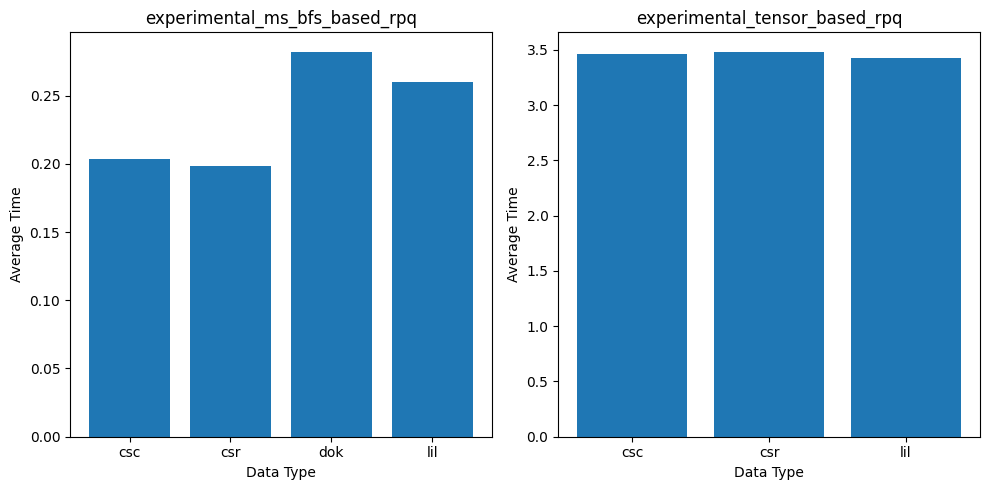

In [17]:
import matplotlib.pyplot as plt

average_times = df.groupby(["algorithm", "matrix_format"])["time"].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, algo in enumerate(average_times["algorithm"].unique()):
    algo_data = average_times[average_times["algorithm"] == algo]

    grouped_data = algo_data.groupby("matrix_format")["time"].mean()

    axes[i].bar(grouped_data.index, grouped_data.values)

    axes[i].set_title(f"{algo}")
    axes[i].set_xlabel("Data Type")
    axes[i].set_ylabel("Average Time")

display(average_times)
plt.tight_layout()
plt.show()


TypeError: agg function failed [how->mean,dtype->object]

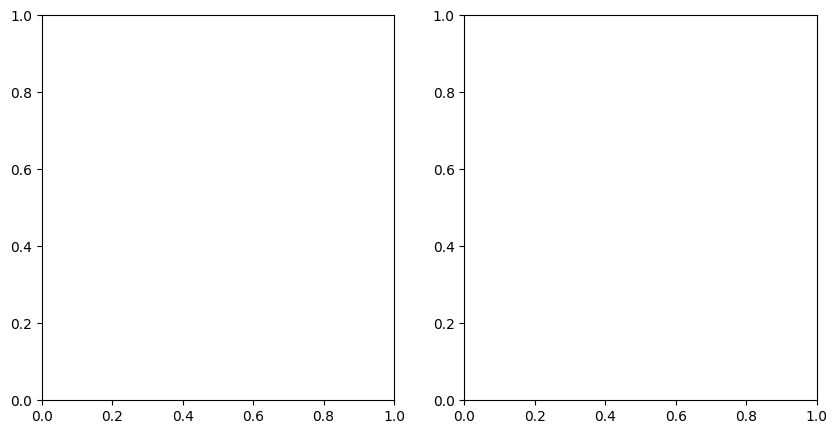

In [52]:
import matplotlib.pyplot as plt

df = pd.DataFrame(results)

average_times = (
    df.groupby(["algorithm", "start_nodes_percentage"])["time"].mean().reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, algo in enumerate(average_times["algorithm"].unique()):
    algo_data = average_times[average_times["algorithm"] == algo]

    grouped_data = algo_data.groupby("start_nodes_percentage")["algorithm"].mean()

    axes[i].bar(grouped_data.index, grouped_data.values)

    axes[i].set_title(f"{algo}")
    axes[i].set_xlabel("Start Nodes %")
    axes[i].set_ylabel("Average Time")

display(average_times)
plt.tight_layout()
plt.show()


In [34]:
df.groupby(["algorithm", "start_nodes_percentage"])["time"].mean().reset_index()

,algorithm,start_nodes_percentage,time
0,experimental_ms_bfs_based_rpq,1001001001001001001001001001001001001001001001...,0.443528
1,experimental_ms_bfs_based_rpq,3030303030303030303030303030303030303030303030...,0.131700
2,experimental_ms_bfs_based_rpq,5050505050505050505050505050505050505050505050...,0.222956
3,experimental_ms_bfs_based_rpq,5555555555555555555555555555555555555555555555...,0.028379
4,experimental_ms_bfs_based_rpq,8080808080808080808080808080808080808080808080...,0.352963
5,experimental_tensor_based_rpq,1001001001001001001001001001001001001001001001...,6.638526
6,experimental_tensor_based_rpq,3030303030303030303030303030303030303030303030...,1.881332
7,experimental_tensor_based_rpq,5050505050505050505050505050505050505050505050...,2.835523
8,experimental_tensor_based_rpq,5555555555555555555555555555555555555555555555...,0.997613
9,experimental_tensor_based_rpq,8080808080808080808080808080808080808080808080...,4.929722


# Описание эксперимента